# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 9

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 439
Num noneffect sequences: 	 439
Num scores: 	 	 	 439


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []
motif_others = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_other = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
                motif_other = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
            motif_other = noneffect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_other = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
                motif_other = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
            motif_other = effect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    motif_others.append(motif_other)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.4557041441986225
Median KS-test p-value: 	 0.43540907209313817
St. Dev KS-test p-value: 	 0.31490583830409097
Max KS-test p-value: 	 	 0.9905790285058053
Min KS-test p-value: 	 	 1.2196064477613159e-15
Num significant p-values: 	 18

Mean non-zero motif length: 	 9.278761061946902
Median non-zero motif length: 	 9.0
St. Dev non-zero motif length: 	 6.185085305473822
Max non-zero motif length: 	 29
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.874715261958997
Median motif length: 	 	 10
St. Dev motif length: 	 	 3.1774423746639244
Max motif length: 	 	 29
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps['motif_other'] = motif_others
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 397


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 397


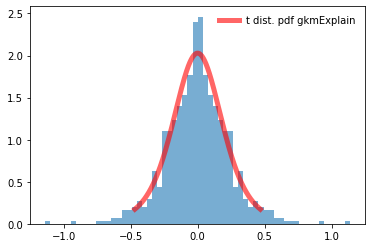

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 5.602008364704197
Mean: 	 -5.064112918689898e-07
Stdev: 	 0.18815788310137332

KstestResult(statistic=0.018347564843469943, pvalue=0.9520208971964849)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 204


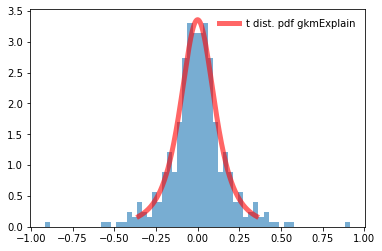

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 2.9215357396664476
Mean: 	 2.4321644122524754e-07
Stdev: 	 0.10921927388911862

KstestResult(statistic=0.018820371026073923, pvalue=0.9987068094238108)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 204


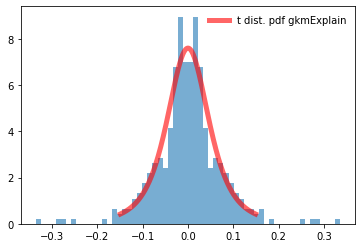

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 3.1923267095947176
Mean: 	 4.849406123723922e-08
Stdev: 	 0.04850665595550212

KstestResult(statistic=0.026184820904899597, pvalue=0.942400384523516)


## Distribution of ISM Scores

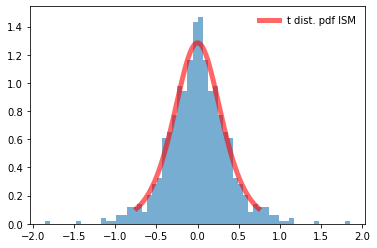

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 5.528913301543806
Mean: 	 3.3613070591877155e-07
Stdev: 	 0.29697848649451886

KstestResult(statistic=0.015851252830675122, pvalue=0.9884259635961761)


## Distribution of Delta Scores

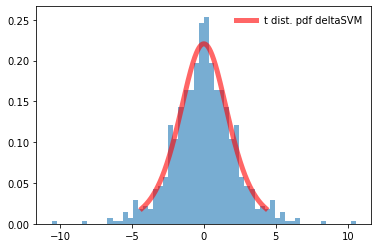

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 5.6051558300612285
Mean: 	 1.632040072915729e-06
Stdev: 	 1.7303613017846153

KstestResult(statistic=0.01683555781376156, pvalue=0.9780124866974726)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.4684525317282033
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.35292546418684684
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.0781669359469587
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.1492395032442702
Negative ISM Cutoff: 	 	 	 	 	 -0.7419557022033578
Negative deltaSVM Cutoff: 	 	 	 	 -4.307400508458486

Total SNPs with Negative Scores: 	 	 	 10
Confident SNPs with Negative Scores: 	 	 	 5
Highly Confident SNPs with Negative Scores: 	 	 3


chr      start        end         rsid effect noneffect ref alt major  \
277  chr19   45326535   45326536     rs344791      C         G   G   C     C   
120  chr17   45848599   45848600   rs62054817      G         A   G   A     G   
410   chr7   23203210   23203211     rs858305      G         C   C   G     C   
323   chr3   49007333   49007334    rs6781790      T         C   C   T     T   
233  chr19   44845919   44845920   rs77241309      C         G   G   C     G   
270  chr19   45001918   45001919   rs35194062      A         C   C   A     C   
278   chr2   95057163   95057164     rs872580      C         A   C   A     A   
339   chr3  122416407  122416408   rs55911744      T         G   T   G     T   
394   chr5  103120549  103120550      rs26523      T         C   C   T     C   
237  chr19   44890258   44890259  rs117310449      T         C   C   T     C   

    minor direction  locus_num  effect_center  noneffect_center  effect_ratio  \
277     G         -         71      -0.002799          0.229700      0.104351   
120     A         +         54       0.628726          1.202351      0.357887   
410     G         -        120      -0.002895          0.279676      0.038254   
323     C         +         92       0.312103          0.710495      0.129978   
233     C         -         71      -0.040169          0.275930      0.003437   
270     A         +         71       0.569292          0.878558      0.187455   
278     C         -         85      -0.072752          0.121325      0.000000   
339     G         -         86       0.014866          0.172340      0.039336   
394     T         -        104      -0.036223          0.040725      0.000000   
237     T         +         71      -0.036683          0.025042      0.000000   

     noneffect_ratio  orig_score  diff_score  ratio_score  ism_score  \
277         0.288466   -0.520238   -0.170109    -0.184114  -0.829558   
120         0.525338   -0.531893   -0.573625    -0.167452  -0.838106   
410         0.187548   -0.484374   -0.235191    -0.149293  -0.756331   
323         0.247309   -0.498117   -0.398392    -0.117331  -0.784908   
233         0.108738   -0.539814   -0.268851    -0.105301  -0.870399   
270         0.265079   -0.495196   -0.309267    -0.077623  -0.881617   
278         0.076870   -0.540151   -0.121325    -0.076870  -0.838087   
339         0.089909   -0.480377   -0.103798    -0.050573  -0.754581   
394         0.025860   -0.606097   -0.040725    -0.025860  -0.947841   
237         0.017284   -0.486037   -0.025042    -0.017284  -0.772922   

     delta_score                      gwas     gwas_pval  coloc  idr_peak  \
277    -4.798768    Alzheimers_Jansen_2018  1.215671e-04   True      True   
120    -4.802895           23andme_PD_hg38  1.136600e-22   True      True   
410    -4.397770  Chang_23andMe_Parkinsons  7.393300e-06  False     False   
323    -4.541427  Chang_23andMe_Parkinsons  2.349340e-03  False      True   
233    -4.998731    Alzheimers_Jansen_2018  5.118586e-10   True      True   
270    -5.172332    Alzheimers_Kunkle_2019  2.384000e-14   True      True   
278    -4.893169             Nalls_23andMe  4.037170e-02  False      True   
339    -4.381121             Nalls_23andMe  4.986370e-04  False      True   
394    -5.462849             Nalls_23andMe  1.084830e-03  False      True   
237    -4.477740    Alzheimers_Jansen_2018  7.042756e-94   True      True   

            motif   motif_other  orig_pval  diff_pval  ratio_pval  ism_pval  \
277     GCCTCCACT     CCCTCCACT   0.035076   0.219617    0.028782  0.034316   
120  CCAGTAGAGGGC  CCGGTAGAGGGC   0.032430   0.014364    0.037117  0.033099   
410     CGCGGCTTC     CGGGGCTTC   0.044791   0.122739    0.049955  0.046969   
323   GAGGGCGCTGT   GAGGGTGCTGT   0.040763   0.037145    0.089091  0.041515   
233       TGAGCTA       TGACCTA   0.030757   0.093026    0.112934  0.028910   
270    GGGGCGGGGC    GGGGCGGGGC   0.041585   0.068177    0.202393  0.027594   
278    CATGGCACTC    CATGGCCCTC   0.0306


Positive Original gkmExplain Cutoff: 	 	 	 0.4684515189056194
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.3529259506197292
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.0781670329350812
Positive Ratio Difference gkmExplain High Cutoff: 	 0.14923960023239263
Positive ISM Cutoff: 	 	 	 	 	 0.7419563744647696
Positive deltaSVM Cutoff: 	 	 	 	 4.307403772538632

Total SNPs with Positive Scores: 	 	 	 12
Confident SNPs with Positive Scores: 	 	 	 9
Highly Confident SNPs with Positive Scores: 	 	 6


chr      start        end        rsid effect noneffect ref    alt  \
150  chr17   45896863   45896864  rs62056782      T         C   C      T   
214  chr19   18438073   18438074   rs2303696      C         T   T      C   
169  chr17   45947293   45947294  rs62062786      G         C   G    A,C   
386   chr4   89836583   89836584   rs2619361      A         C   C      A   
167  chr17   45947185   45947186  rs62062784      G         C   C      G   
193  chr17   46771150   46771151    rs199523      C         A   C      A   
415   chr7  100217743  100217744   rs1727139      C         T   C    G,T   
159  chr17   45940574   45940575  rs62061732      T         G   G      T   
89   chr17   45442197   45442198  rs34887474      C         A   C      A   
81   chr17    4908319    4908320   rs7214776      C         T   T      C   
251  chr19   44915228   44915229  rs12691088      A         G   G    A,C   
283   chr2   95297493   95297494   rs2248415      G         C   C  A,G,T   

    major  minor direction  locus_num  effect_center  noneffect_center  \
150     C      T         -         54       1.196958          0.284150   
214     C      T         +         69       0.564402         -0.020760   
169     G    A,C         +         54       0.450990         -0.458147   
386     C      A         +        103       0.448884          0.030249   
167     C      G         -         54       0.442460         -0.155354   
193     A      C         -         54       0.784733          0.286931   
415     T    C,G         -        117       0.535722          0.234764   
159     G      T         -         54       0.087512         -0.219399   
89      C      A         +         54       1.125517          0.717088   
81      T      C         +         55       0.041395         -0.110674   
251     G    A,C         +         71       0.000000          0.000000   
283     G  C,A,T         +         85       0.000000          0.000000   

     effect_ratio  noneffect_ratio  orig_score  diff_score  ratio_score  \
150      0.593079         0.257135    0.934940    0.912808     0.335943   
214      0.303992         0.017337    0.633876    0.542386     0.286655   
169      0.279171         0.003922    1.135914    0.446528     0.275249   
386      0.286727         0.037705    0.541857    0.408286     0.249022   
167      0.193621         0.025655    0.674134    0.394896     0.167967   
193      0.286724         0.136893    0.584162    0.480278     0.149831   
415      0.334889         0.232644    0.511747    0.249446     0.102245   
159      0.086033         0.000000    0.721641    0.087512     0.086033   
89       0.626108         0.569293    0.593053    0.360113     0.056815   
81       0.039964         0.000000    0.706045    0.041395     0.039964   
251      0.000000         0.000000    0.553739    0.000000     0.000000   
283      0.000000         0.000000    0.519467    0.000000     0.000000   

     ism_score  delta_score                     gwas      gwas_pval  coloc  \
150   1.460152     8.361362          23andme_PD_hg38   3.938570e-22   True   
214   1.017336     5.758931   Alzheimers_Kunkle_2019   1.893000e-05   True   
169   1.851118    10.572556          23andme_PD_hg38   4.529580e-22   True   
386   0.847975     4.907734          23andme_PD_hg38   1.360700e-08   True   
167   1.055260     6.146321          23andme_PD_hg38   3.332810e-22   True   
193   0.927545     5.367414          23andme_PD_hg38   9.492900e-14   True   
415   0.797030     4.653590   Alzheimers_Jansen_2018   9.848070e-10   True   
159   1.127573     6.488224          23andme_PD_hg38   3.035590e-22   True   
89    0.921094     5.387904          23andme_PD_hg38   3.431660e-21   True   
81    1.112101     6.395140  Alzheimers_Lambert_2013   4.266000e-05   True   
251   0.926475     5.345199   Alzheimers_Kunkle_2019  2.690000e-238   True   
283   0.831906     4.815891            Nalls_23andMe   7.828270e-03  False   

     idr_peak                motif          motif_other  orig_pv

# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 277

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.2157E-04   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: G   ||   Noneffect Center: 0.2297   ||   Center / 200bp : 0.2885

Noneffect Motif: GCCTCCACT


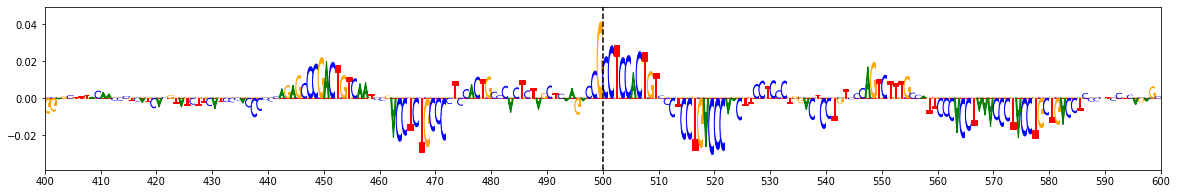

Effect Allele: C   ||   Effect Center: -0.0028   ||   Center / 200bp : 0.1044

Effect Motif: CCCTCCACT


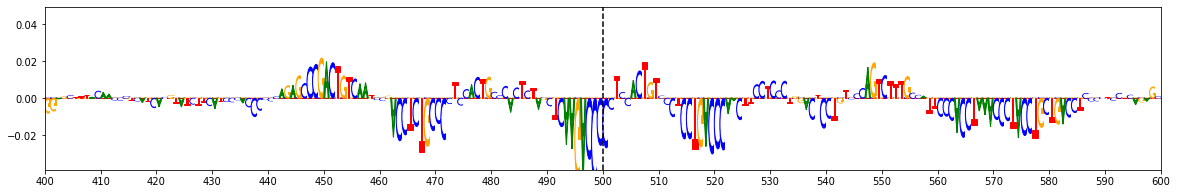

gkmExplain Score: -0.1841  ||  ISM Score: -0.8296  ||  deltaSVM Score: -4.7988

gkmExplain P-Value: 0.028782  ||  ISM P-Value: 0.034316  ||  deltaSVM P-Value: 0.034684

Difference Motif: (G/C)CCTCCACT


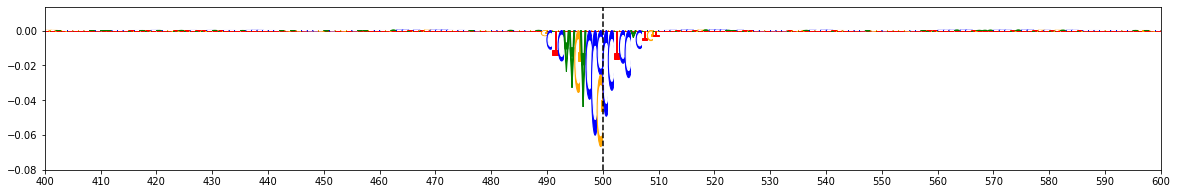



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 120

RSID: rs62054817   ||    chr17 : 45848599 - 45848600   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.1366E-22   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: A   ||   Noneffect Center: 1.2024   ||   Center / 200bp : 0.5253

Noneffect Motif: CCAGTAGAGGGC


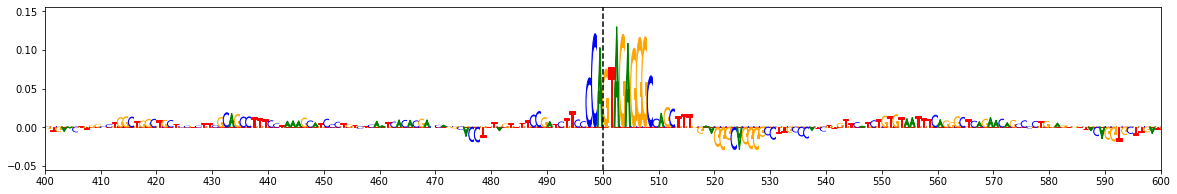

Effect Allele: G   ||   Effect Center: 0.6287   ||   Center / 200bp : 0.3579

Effect Motif: CCGGTAGAGGGC


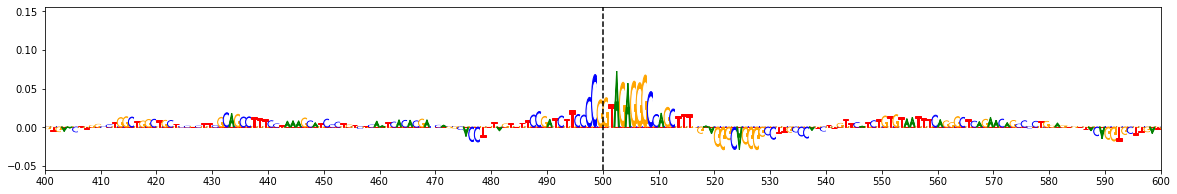

gkmExplain Score: -0.1675  ||  ISM Score: -0.8381  ||  deltaSVM Score: -4.8029

gkmExplain P-Value: 0.037117  ||  ISM P-Value: 0.033099  ||  deltaSVM P-Value: 0.034579

Difference Motif: CC(A/G)GTAGAGGGC


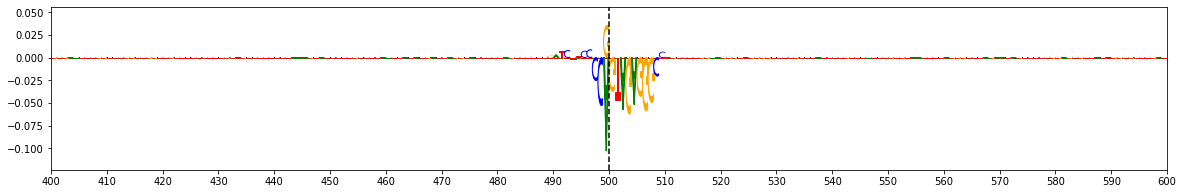



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 410

RSID: rs858305   ||    chr7 : 23203210 - 23203211   ||    Locus: 120   ||    IDR Peak: False

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 7.3933E-06   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.2797   ||   Center / 200bp : 0.1875

Noneffect Motif: CGCGGCTTC


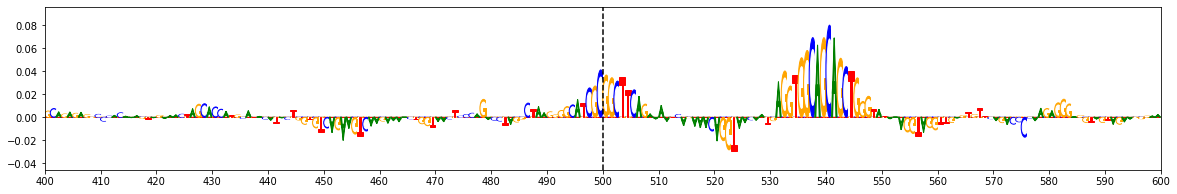

Effect Allele: G   ||   Effect Center: -0.0029   ||   Center / 200bp : 0.0383

Effect Motif: CGGGGCTTC


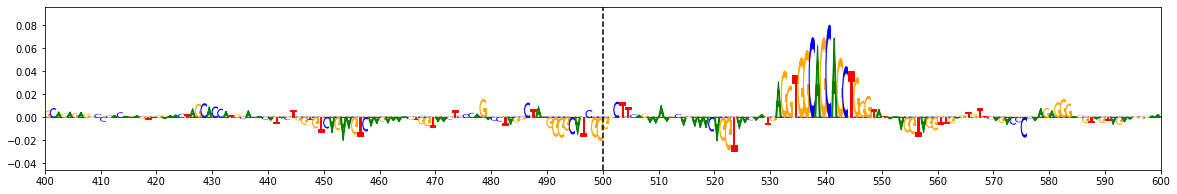

gkmExplain Score: -0.1493  ||  ISM Score: -0.7563  ||  deltaSVM Score: -4.3978

gkmExplain P-Value: 0.049955  ||  ISM P-Value: 0.046969  ||  deltaSVM P-Value: 0.046712

Difference Motif: CG(C/G)GGCTTC


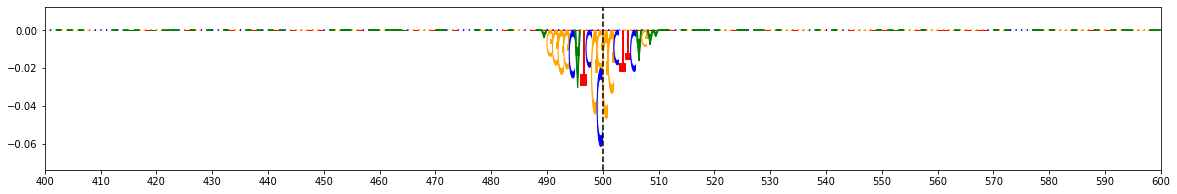



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 323

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 0.7105   ||   Center / 200bp : 0.2473

Noneffect Motif: GAGGGCGCTGT


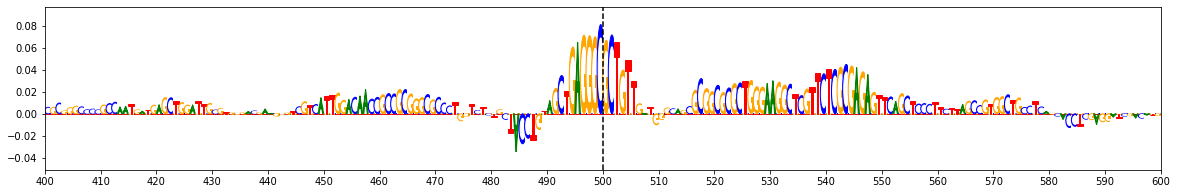

Effect Allele: T   ||   Effect Center: 0.3121   ||   Center / 200bp : 0.13

Effect Motif: GAGGGTGCTGT


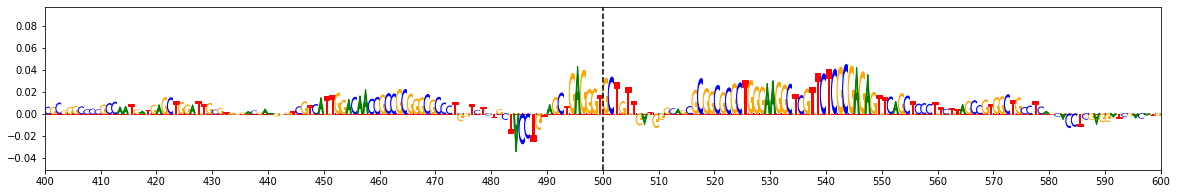

gkmExplain Score: -0.1173  ||  ISM Score: -0.7849  ||  deltaSVM Score: -4.5414

gkmExplain P-Value: 0.089091  ||  ISM P-Value: 0.041515  ||  deltaSVM P-Value: 0.041953

Difference Motif: GAGGG(C/T)GCTGT


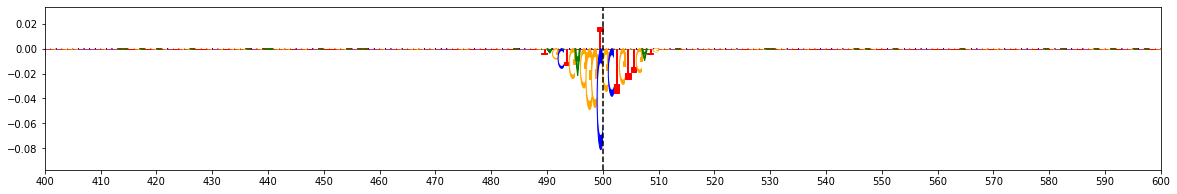



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 233

RSID: rs77241309   ||    chr19 : 44845919 - 44845920   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 5.1186E-10   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.2759   ||   Center / 200bp : 0.1087

Noneffect Motif: TGAGCTA


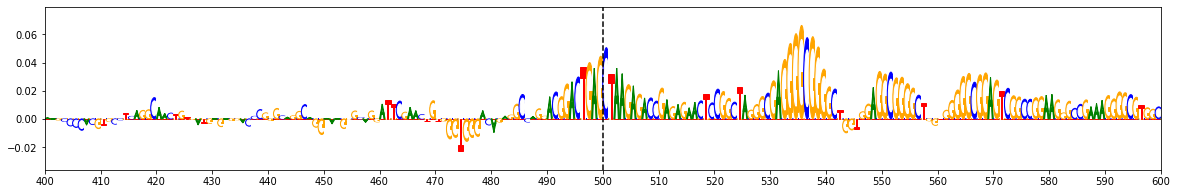

Effect Allele: C   ||   Effect Center: -0.0402   ||   Center / 200bp : 0.0034

Effect Motif: TGACCTA


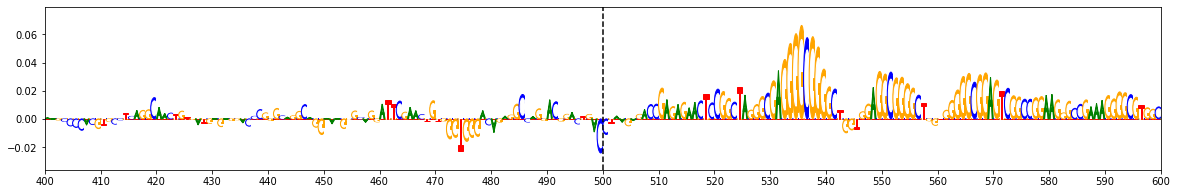

gkmExplain Score: -0.1053  ||  ISM Score: -0.8704  ||  deltaSVM Score: -4.9987

gkmExplain P-Value: 0.112934  ||  ISM P-Value: 0.02891  ||  deltaSVM P-Value: 0.029979

Difference Motif: TGA(G/C)CTA


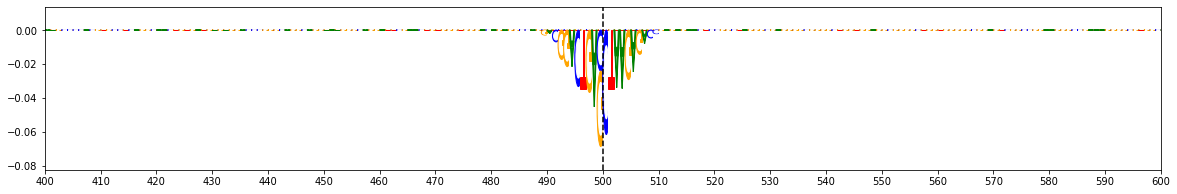



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 270

RSID: rs35194062   ||    chr19 : 45001918 - 45001919   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.3840E-14   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.8786   ||   Center / 200bp : 0.2651

Noneffect Motif: GGGGCGGGGC


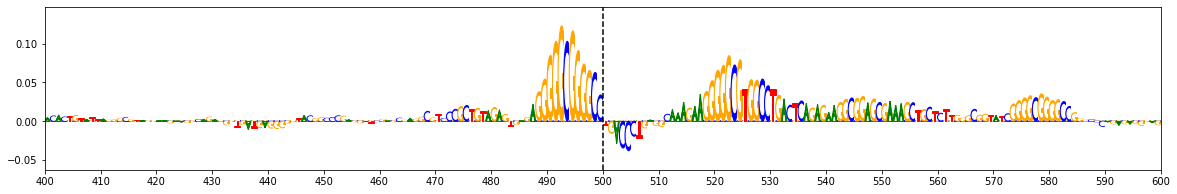

Effect Allele: A   ||   Effect Center: 0.5693   ||   Center / 200bp : 0.1875

Effect Motif: GGGGCGGGGC


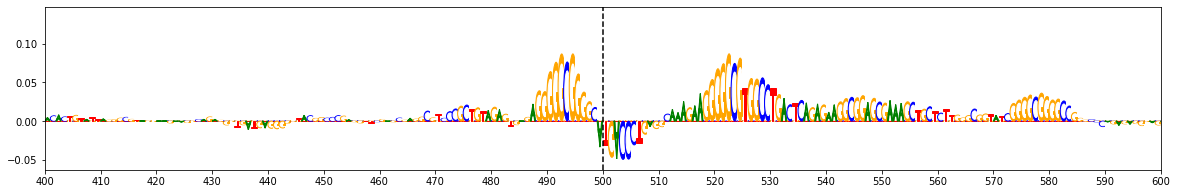

gkmExplain Score: -0.0776  ||  ISM Score: -0.8816  ||  deltaSVM Score: -5.1723

gkmExplain P-Value: 0.202393  ||  ISM P-Value: 0.027594  ||  deltaSVM P-Value: 0.026457

Difference Motif: GGGGCGGGGC(C/A)


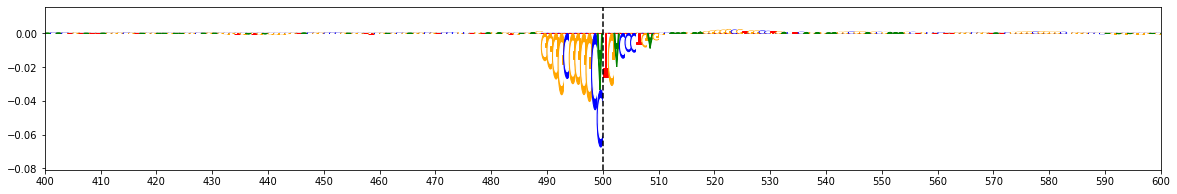



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 278

RSID: rs872580   ||    chr2 : 95057163 - 95057164   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.0372E-02   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: A   ||   Noneffect Center: 0.1213   ||   Center / 200bp : 0.0769

Noneffect Motif: CATGGCACTC


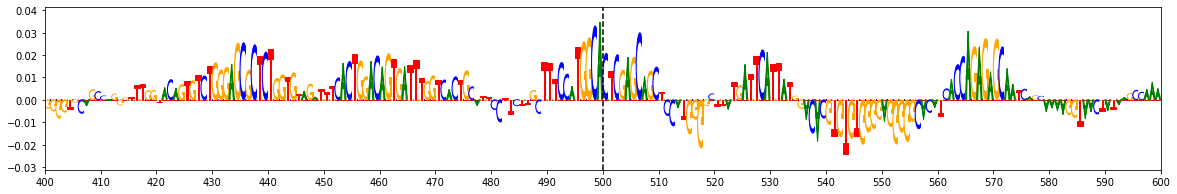

Effect Allele: C   ||   Effect Center: -0.0728   ||   Center / 200bp : 0.0

Effect Motif: CATGGCCCTC


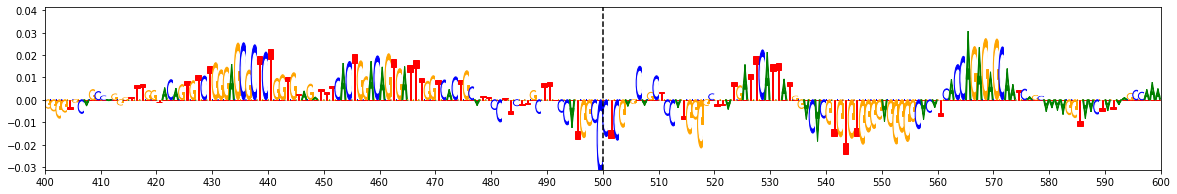

gkmExplain Score: -0.0769  ||  ISM Score: -0.8381  ||  deltaSVM Score: -4.8932

gkmExplain P-Value: 0.205759  ||  ISM P-Value: 0.033102  ||  deltaSVM P-Value: 0.03237

Difference Motif: CATGGC(A/C)CTC


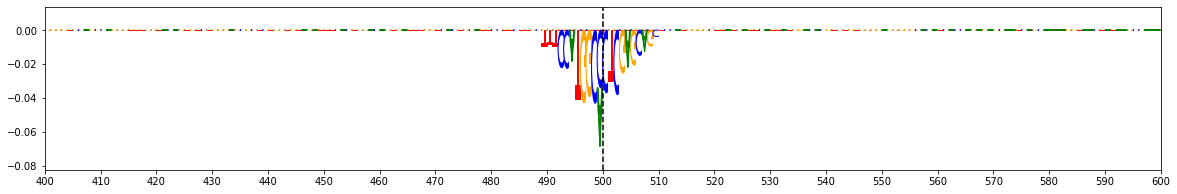



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 339

RSID: rs55911744   ||    chr3 : 122416407 - 122416408   ||    Locus: 86   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.9864E-04   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.1723   ||   Center / 200bp : 0.0899

Noneffect Motif: GGACGCG


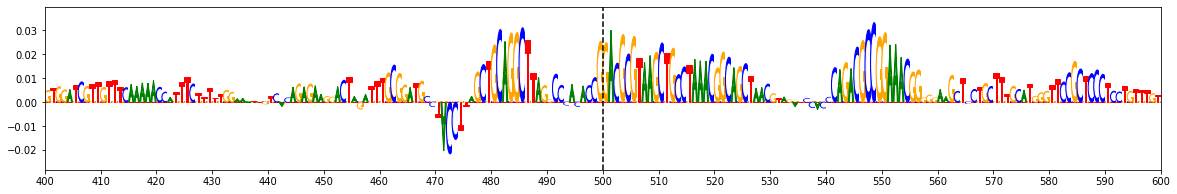

Effect Allele: T   ||   Effect Center: 0.0149   ||   Center / 200bp : 0.0393

Effect Motif: TGACGCG


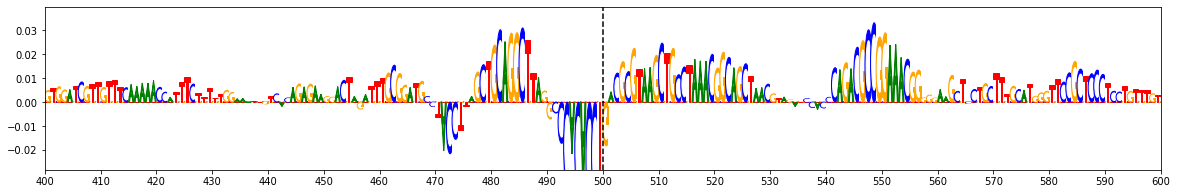

gkmExplain Score: -0.0506  ||  ISM Score: -0.7546  ||  deltaSVM Score: -4.3811

gkmExplain P-Value: 0.369559  ||  ISM P-Value: 0.047327  ||  deltaSVM P-Value: 0.0473

Difference Motif: (G/T)GACGCG


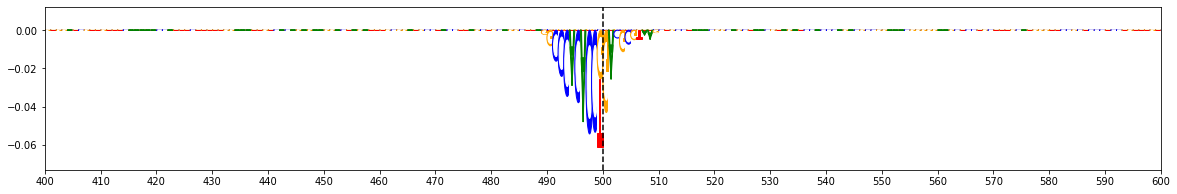



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 394

RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 104   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 1.0848E-03   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.0407   ||   Center / 200bp : 0.0259

Noneffect Motif: GAGGCGGCTG


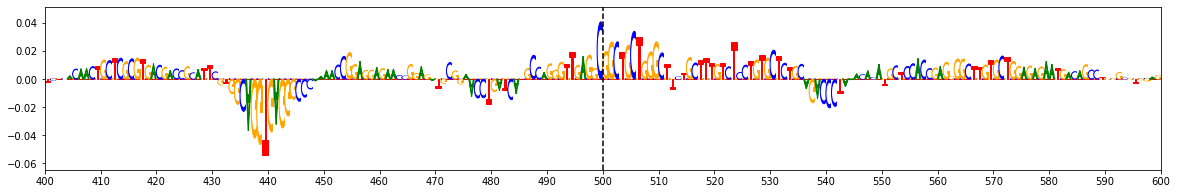

Effect Allele: T   ||   Effect Center: -0.0362   ||   Center / 200bp : 0.0

Effect Motif: GAGGTGGCTG


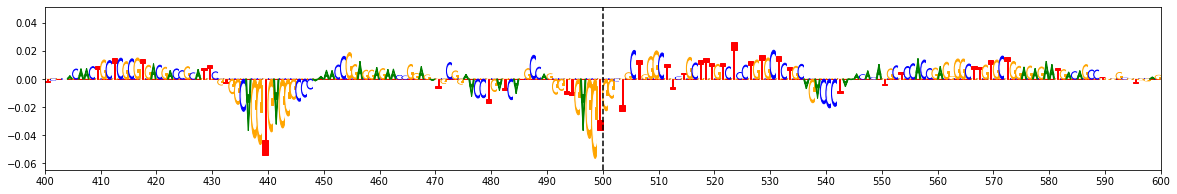

gkmExplain Score: -0.0259  ||  ISM Score: -0.9478  ||  deltaSVM Score: -5.4628

gkmExplain P-Value: 0.628843  ||  ISM P-Value: 0.021049  ||  deltaSVM P-Value: 0.021535

Difference Motif: GAGG(C/T)GGCTG


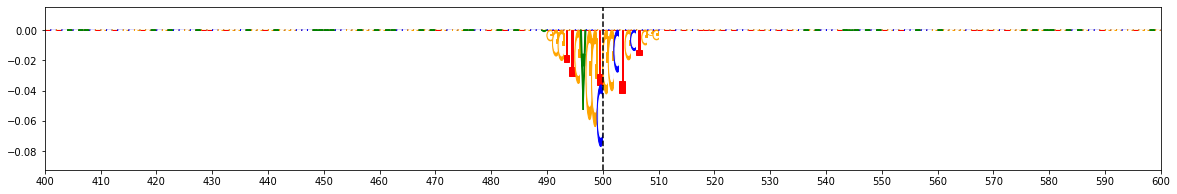



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 237

RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 7.0428E-94   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.025   ||   Center / 200bp : 0.0173

Noneffect Motif: GAGGCAGAGT


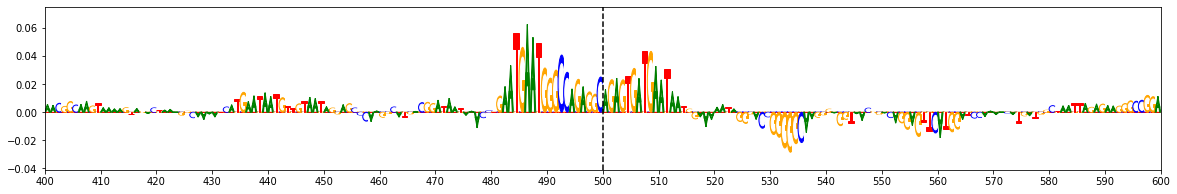

Effect Allele: T   ||   Effect Center: -0.0367   ||   Center / 200bp : 0.0

Effect Motif: GAGGTAGAGT


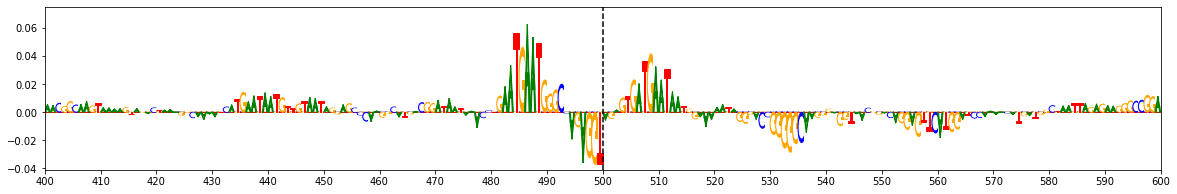

gkmExplain Score: -0.0173  ||  ISM Score: -0.7729  ||  deltaSVM Score: -4.4777

gkmExplain P-Value: 0.743855  ||  ISM P-Value: 0.043715  ||  deltaSVM P-Value: 0.043995

Difference Motif: GAGG(C/T)AGAGT


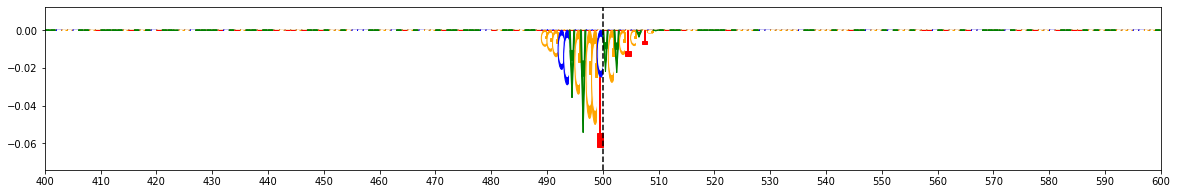



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif_other'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 150

RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 3.9386E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 1.197   ||   Center / 200bp : 0.5931

Effect Motif: CGCCCTCTTGTG


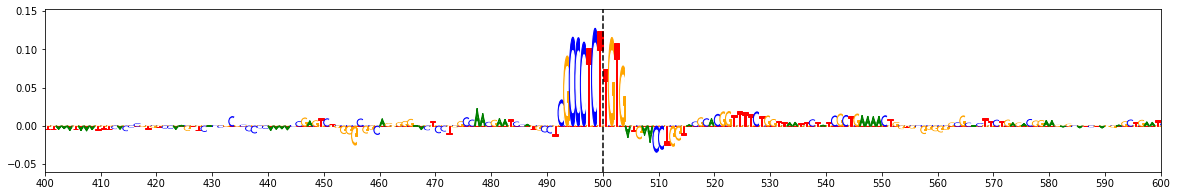

Noneffect Allele: C   ||   Noneffect Center: 0.2841   ||   Center / 200bp : 0.2571

Noneffect Motif: CGCCCTCCTGTG


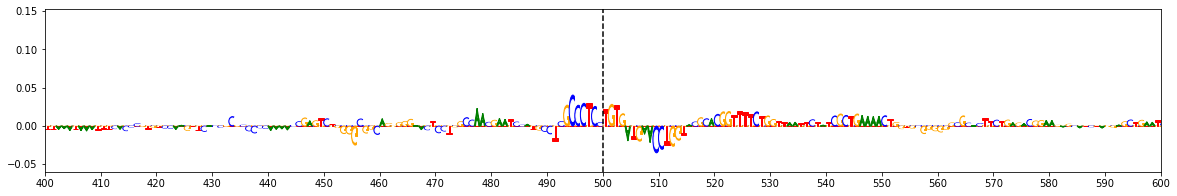

gkmExplain Score: 0.3359  ||  ISM Score: 1.4602  ||  deltaSVM Score: 8.3614

gkmExplain P-Value: 0.005033  ||  ISM P-Value: 0.003348  ||  deltaSVM P-Value: 0.003496

Difference Motif: CGCCCTC(T/C)TGTG


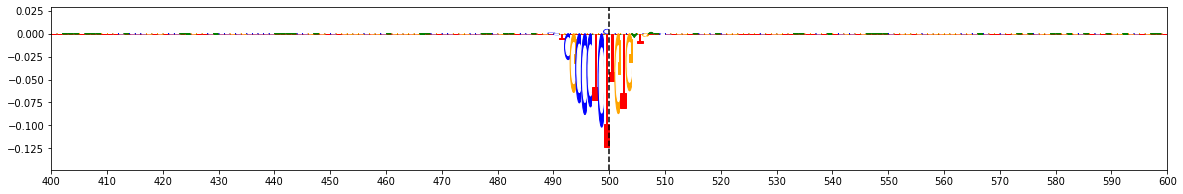



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 214

RSID: rs2303696   ||    chr19 : 18438073 - 18438074   ||    Locus: 69   ||    IDR Peak: False

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.8930E-05   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 0.5644   ||   Center / 200bp : 0.304

Effect Motif: GTCCCCGCCCC


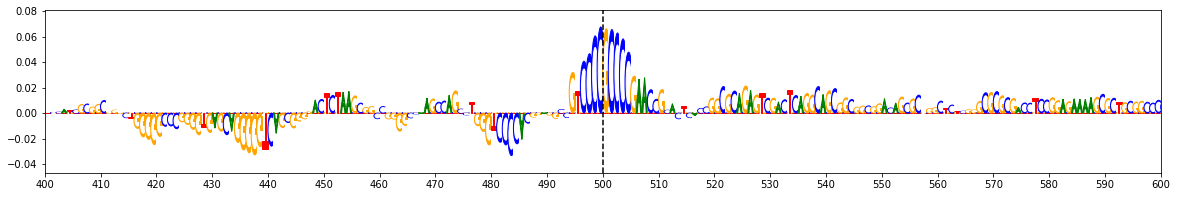

Noneffect Allele: T   ||   Noneffect Center: -0.0208   ||   Center / 200bp : 0.0173

Noneffect Motif: GTCCCTGCCCC


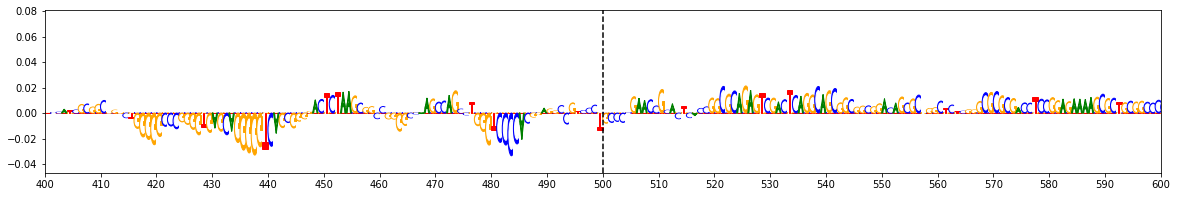

gkmExplain Score: 0.2867  ||  ISM Score: 1.0173  ||  deltaSVM Score: 5.7589

gkmExplain P-Value: 0.008107  ||  ISM P-Value: 0.015974  ||  deltaSVM P-Value: 0.017537

Difference Motif: GTCCC(C/T)GCCCC


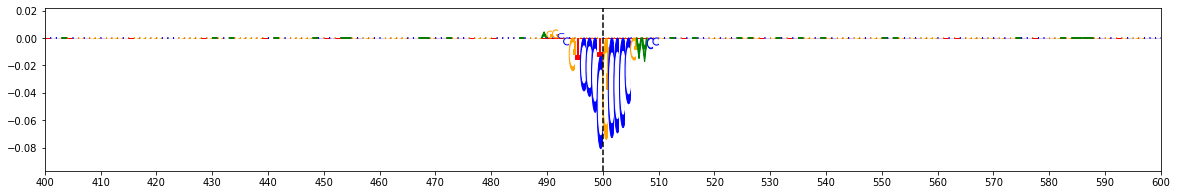



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 169

RSID: rs62062786   ||    chr17 : 45947293 - 45947294   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 4.5296E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.451   ||   Center / 200bp : 0.2792

Effect Motif: CAGCTGCCACA


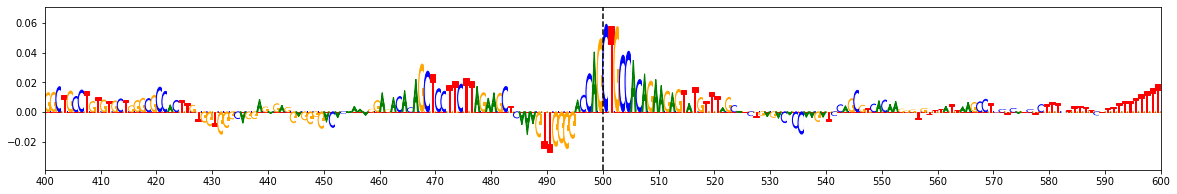

Noneffect Allele: C   ||   Noneffect Center: -0.4581   ||   Center / 200bp : 0.0039

Noneffect Motif: CACCTGCCACA


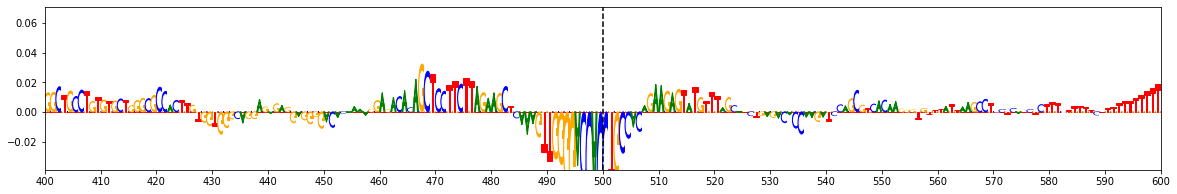

gkmExplain Score: 0.2752  ||  ISM Score: 1.8511  ||  deltaSVM Score: 10.5726

gkmExplain P-Value: 0.009145  ||  ISM P-Value: 0.001075  ||  deltaSVM P-Value: 0.001128

Difference Motif: CA(G/C)CTGCCACA


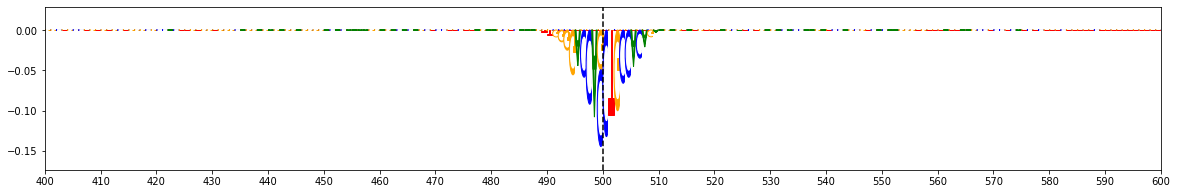



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 386

RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 103   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.3607E-08   ||    Coloc: True   ||    Confidence: 2


Effect Allele: A   ||   Effect Center: 0.4489   ||   Center / 200bp : 0.2867

Effect Motif: TCTTTCATTA


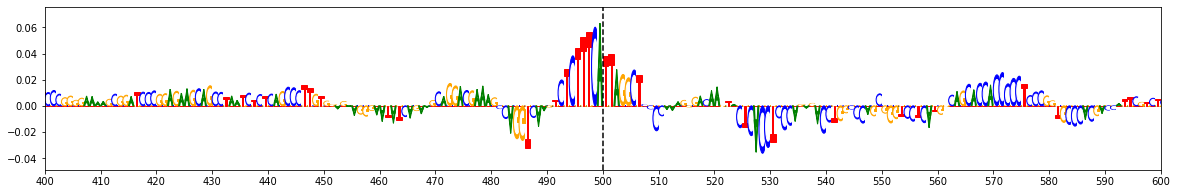

Noneffect Allele: C   ||   Noneffect Center: 0.0302   ||   Center / 200bp : 0.0377

Noneffect Motif: TCTTTCCTTA


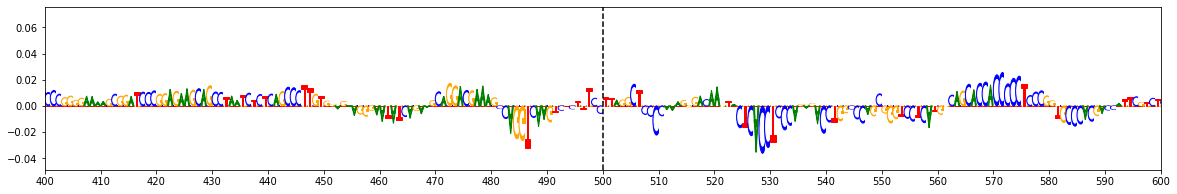

gkmExplain Score: 0.249  ||  ISM Score: 0.848  ||  deltaSVM Score: 4.9077

gkmExplain P-Value: 0.012271  ||  ISM P-Value: 0.031753  ||  deltaSVM P-Value: 0.032028

Difference Motif: TCTTTC(A/C)TTA


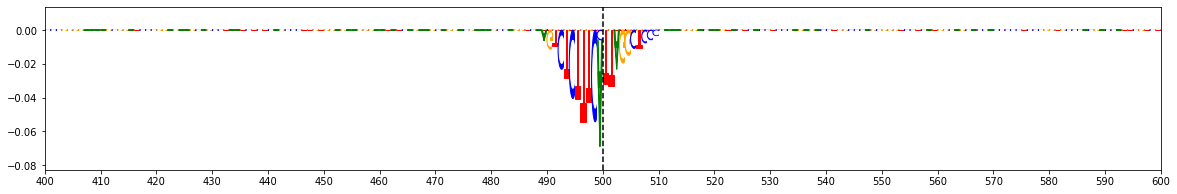



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 167

RSID: rs62062784   ||    chr17 : 45947185 - 45947186   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.3328E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.4425   ||   Center / 200bp : 0.1936

Effect Motif: TTACTGAGCAGC


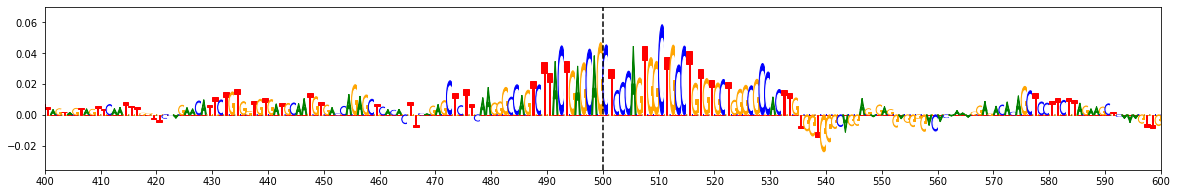

Noneffect Allele: C   ||   Noneffect Center: -0.1554   ||   Center / 200bp : 0.0257

Noneffect Motif: TTACTGAGCACC


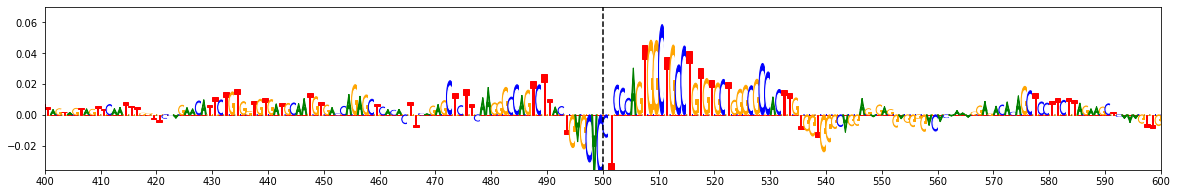

gkmExplain Score: 0.168  ||  ISM Score: 1.0553  ||  deltaSVM Score: 6.1463

gkmExplain P-Value: 0.036817  ||  ISM P-Value: 0.013791  ||  deltaSVM P-Value: 0.013497

Difference Motif: TTACTGAGCA(G/C)C


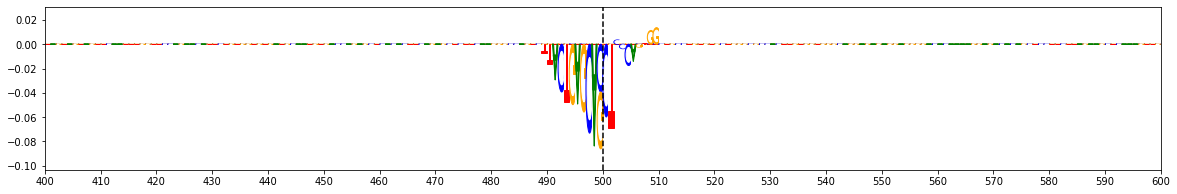



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 193

RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 9.4929E-14   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 0.7847   ||   Center / 200bp : 0.2867

Effect Motif: CGCCACCTACAG


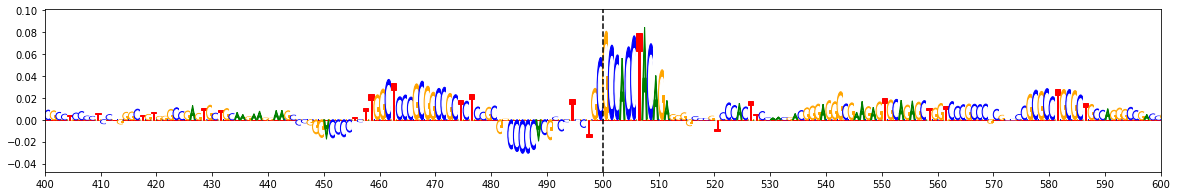

Noneffect Allele: A   ||   Noneffect Center: 0.2869   ||   Center / 200bp : 0.1369

Noneffect Motif: AGCCACCTACAG


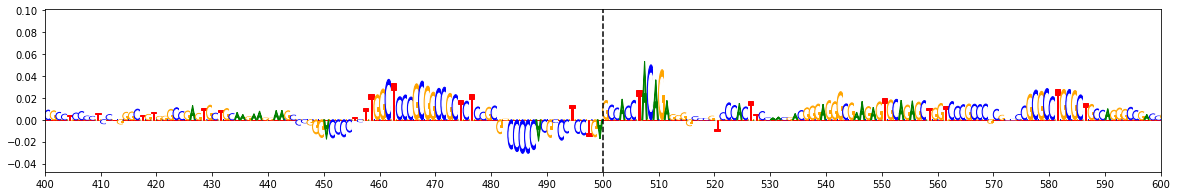

gkmExplain Score: 0.1498  ||  ISM Score: 0.9275  ||  deltaSVM Score: 5.3674

gkmExplain P-Value: 0.049501  ||  ISM P-Value: 0.022852  ||  deltaSVM P-Value: 0.02303

Difference Motif: (C/A)GCCACCTACAG


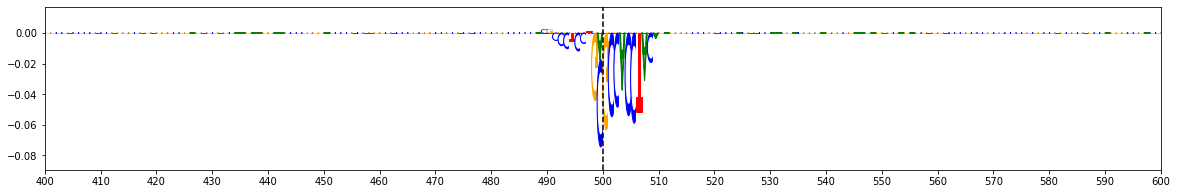



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 415

RSID: rs1727139   ||    chr7 : 100217743 - 100217744   ||    Locus: 117   ||    IDR Peak: False

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 9.8481E-10   ||    Coloc: True   ||    Confidence: 1


Effect Allele: C   ||   Effect Center: 0.5357   ||   Center / 200bp : 0.3349

Effect Motif: GCGGAGAGAGAGAG


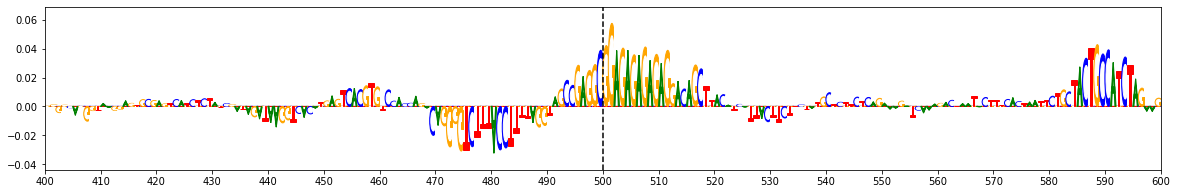

Noneffect Allele: T   ||   Noneffect Center: 0.2348   ||   Center / 200bp : 0.2326

Noneffect Motif: GTGGAGAGAGAGAG


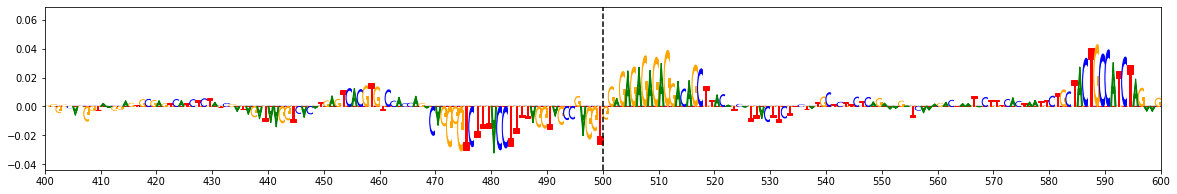

gkmExplain Score: 0.1022  ||  ISM Score: 0.797  ||  deltaSVM Score: 4.6536

gkmExplain P-Value: 0.12015  ||  ISM P-Value: 0.039411  ||  deltaSVM P-Value: 0.0386

Difference Motif: G(C/T)GGAGAGAGAGAG


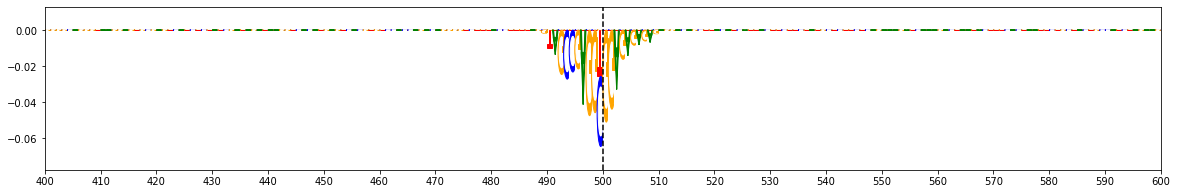



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 159

RSID: rs62061732   ||    chr17 : 45940574 - 45940575   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.0356E-22   ||    Coloc: True   ||    Confidence: 1


Effect Allele: T   ||   Effect Center: 0.0875   ||   Center / 200bp : 0.086

Effect Motif: GCCCAGTTAA


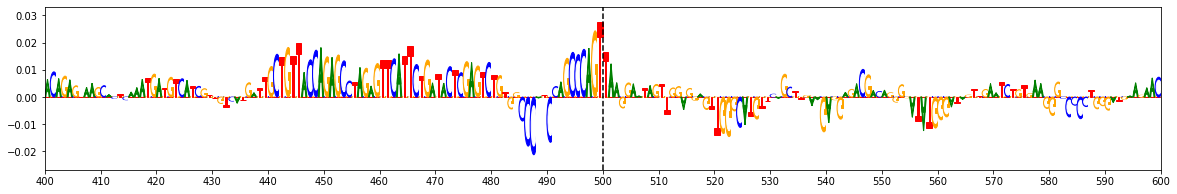

Noneffect Allele: G   ||   Noneffect Center: -0.2194   ||   Center / 200bp : 0.0

Noneffect Motif: GCCCAGGTAA


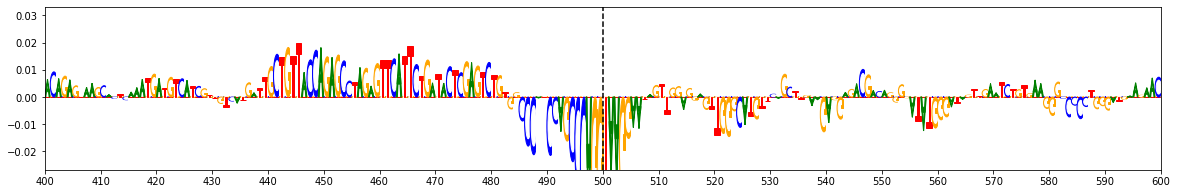

gkmExplain Score: 0.086  ||  ISM Score: 1.1276  ||  deltaSVM Score: 6.4882

gkmExplain P-Value: 0.168668  ||  ISM P-Value: 0.010495  ||  deltaSVM P-Value: 0.010782

Difference Motif: GCCCAG(T/G)TAA


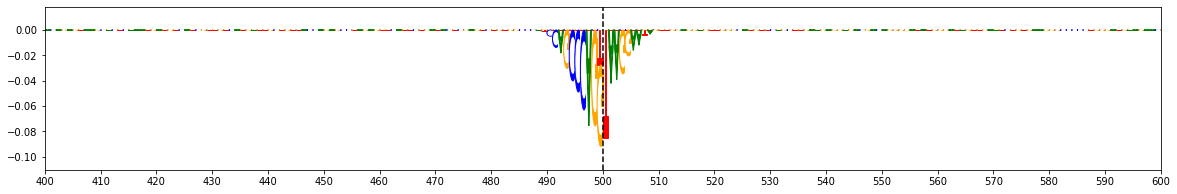



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 89

RSID: rs34887474   ||    chr17 : 45442197 - 45442198   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 3.4317E-21   ||    Coloc: True   ||    Confidence: 1


Effect Allele: C   ||   Effect Center: 1.1255   ||   Center / 200bp : 0.6261

Effect Motif: TGCCAGGCAGCTGCCACTA


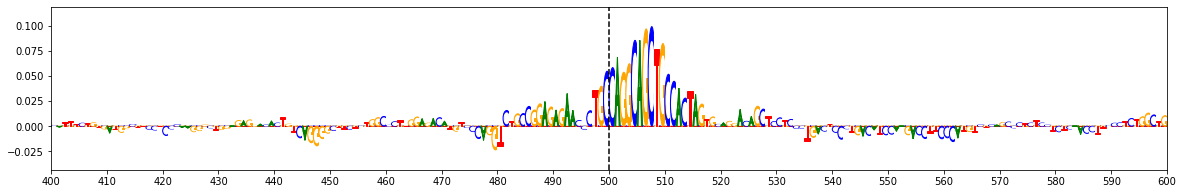

Noneffect Allele: A   ||   Noneffect Center: 0.7171   ||   Center / 200bp : 0.5693

Noneffect Motif: TGACAGGCAGCTGCCACTA


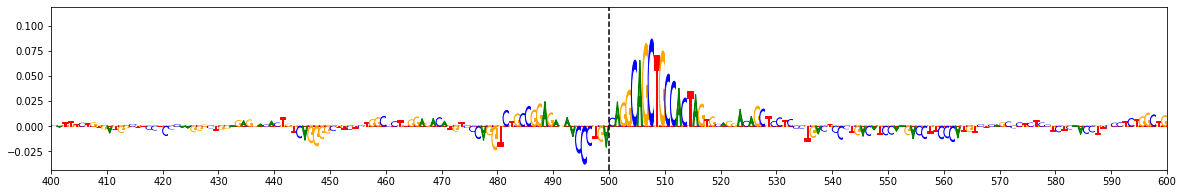

gkmExplain Score: 0.0568  ||  ISM Score: 0.9211  ||  deltaSVM Score: 5.3879

gkmExplain P-Value: 0.321435  ||  ISM P-Value: 0.02346  ||  deltaSVM P-Value: 0.0227

Difference Motif: TG(C/A)CAGGCAGCTGCCACTA


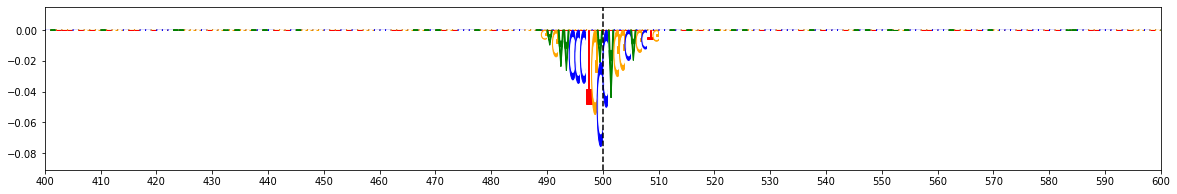



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 81

RSID: rs7214776   ||    chr17 : 4908319 - 4908320   ||    Locus: 55   ||    IDR Peak: False

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.2660E-05   ||    Coloc: True   ||    Confidence: 0


Effect Allele: C   ||   Effect Center: 0.0414   ||   Center / 200bp : 0.04

Effect Motif: CACCCGAGAG


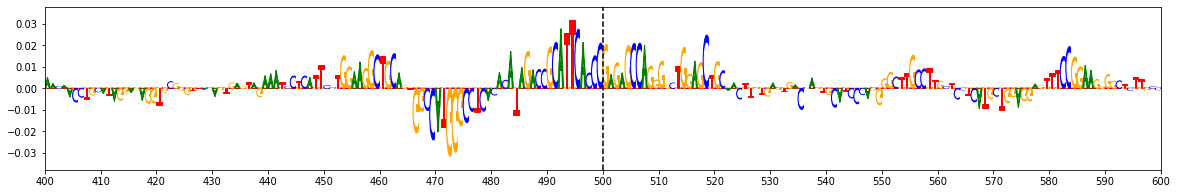

Noneffect Allele: T   ||   Noneffect Center: -0.1107   ||   Center / 200bp : 0.0

Noneffect Motif: CACCTGAGAG


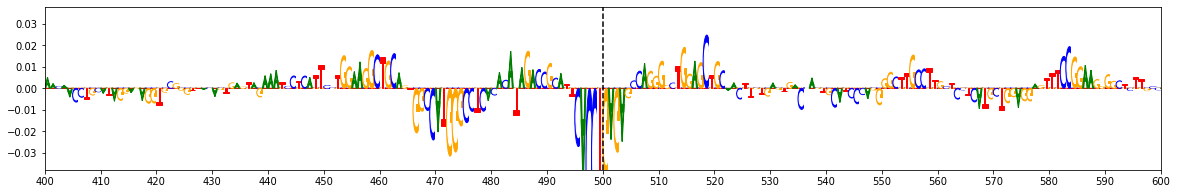

gkmExplain Score: 0.04  ||  ISM Score: 1.1121  ||  deltaSVM Score: 6.3951

gkmExplain P-Value: 0.467064  ||  ISM P-Value: 0.011118  ||  deltaSVM P-Value: 0.011455

Difference Motif: CACC(C/T)GAGAG


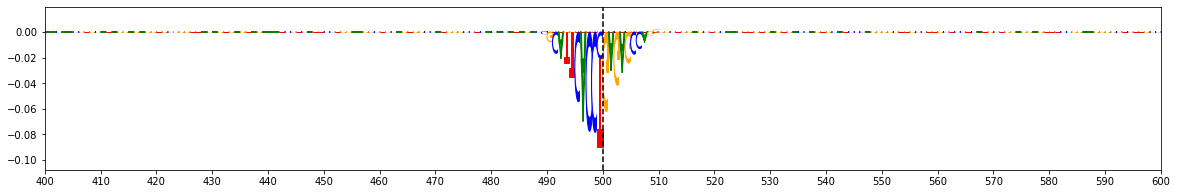



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 251

RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.6900E-238   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTAGGGGG


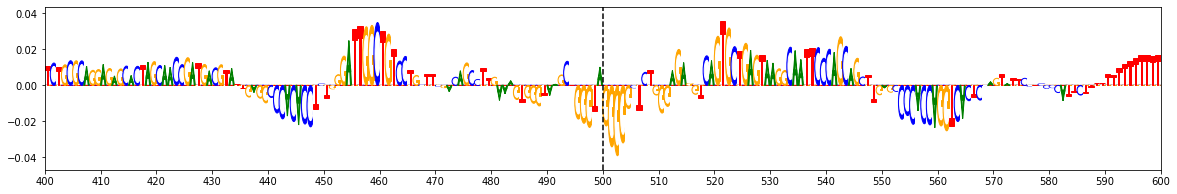

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTGGGGGG


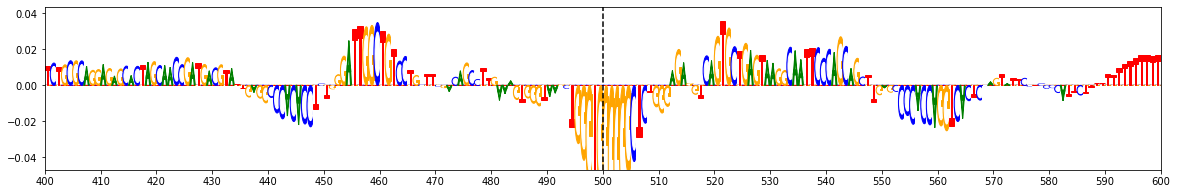

gkmExplain Score: 0.0  ||  ISM Score: 0.9265  ||  deltaSVM Score: 5.3452

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.022951  ||  deltaSVM P-Value: 0.023395

Difference Motif: GGGT(A/G)GGGGG


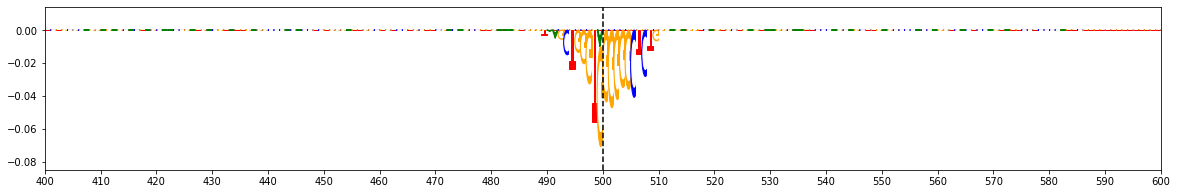



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 283

RSID: rs2248415   ||    chr2 : 95297493 - 95297494   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 7.8283E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTGGGGGG


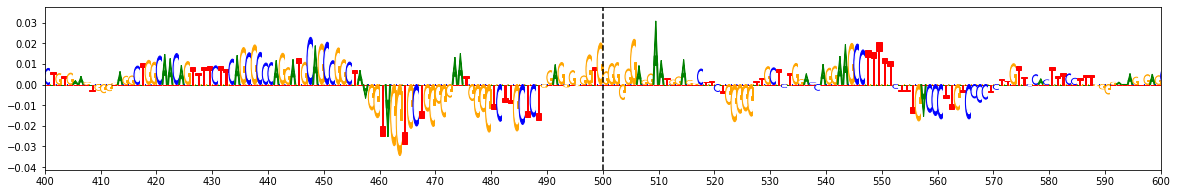

Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTCGGGGG


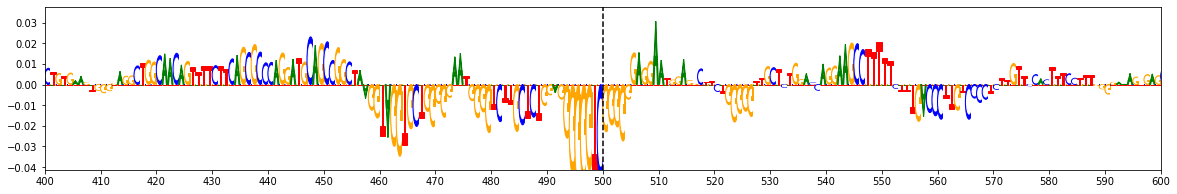

gkmExplain Score: 0.0  ||  ISM Score: 0.8319  ||  deltaSVM Score: 4.8159

gkmExplain P-Value: 0.999999  ||  ISM P-Value: 0.033977  ||  deltaSVM P-Value: 0.034251

Difference Motif: GGGT(G/C)GGGGG


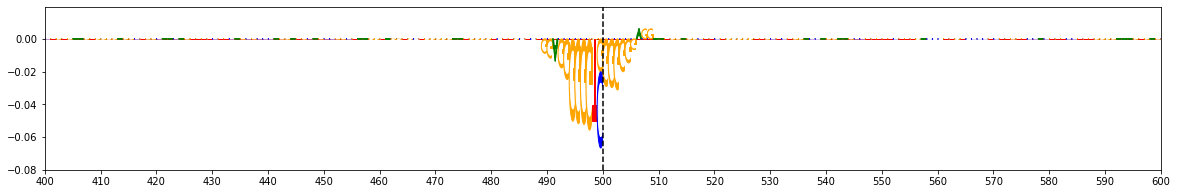



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif_other'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:1.2411918640136719
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 1

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:py

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.09480500221252441
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plot

INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygeno

INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.09751629829406738
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. 

INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:

INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04763484001159668
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spac

INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:

INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INF

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1054072380065918
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 1

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

chr      start        end         rsid effect noneffect direction  \
150  chr17   45896863   45896864   rs62056782      T         C         -   
214  chr19   18438073   18438074    rs2303696      C         T         +   
169  chr17   45947293   45947294   rs62062786      G         C         +   
386   chr4   89836583   89836584    rs2619361      A         C         +   
277  chr19   45326535   45326536     rs344791      C         G         -   
167  chr17   45947185   45947186   rs62062784      G         C         -   
120  chr17   45848599   45848600   rs62054817      G         A         +   
193  chr17   46771150   46771151     rs199523      C         A         -   
410   chr7   23203210   23203211     rs858305      G         C         -   
323   chr3   49007333   49007334    rs6781790      T         C         +   
233  chr19   44845919   44845920   rs77241309      C         G         -   
415   chr7  100217743  100217744    rs1727139      C         T         -   
159  chr17   45940574   45940575   rs62061732      T         G         -   
270  chr19   45001918   45001919   rs35194062      A         C         +   
278   chr2   95057163   95057164     rs872580      C         A         -   
89   chr17   45442197   45442198   rs34887474      C         A         +   
339   chr3  122416407  122416408   rs55911744      T         G         -   
81   chr17    4908319    4908320    rs7214776      C         T         +   
394   chr5  103120549  103120550      rs26523      T         C         -   
237  chr19   44890258   44890259  rs117310449      T         C         +   
251  chr19   44915228   44915229   rs12691088      A         G         +   
283   chr2   95297493   95297494    rs2248415      G         C         +   

     locus_num                      gwas      gwas_pval  coloc  idr_peak  \
150         54           23andme_PD_hg38   3.938570e-22   True     False   
214         69    Alzheimers_Kunkle_2019   1.893000e-05   True     False   
169         54           23andme_PD_hg38   4.529580e-22   True      True   
386        103           23andme_PD_hg38   1.360700e-08   True      True   
277         71    Alzheimers_Jansen_2018   1.215671e-04   True      True   
167         54           23andme_PD_hg38   3.332810e-22   True      True   
120         54           23andme_PD_hg38   1.136600e-22   True      True   
193         54           23andme_PD_hg38   9.492900e-14   True      True   
410        120  Chang_23andMe_Parkinsons   7.393300e-06  False     False   
323         92  Chang_23andMe_Parkinsons   2.349340e-03  False      True   
233         71    Alzheimers_Jansen_2018   5.118586e-10   True      True   
415        117    Alzheimers_Jansen_2018   9.848070e-10   True     False   
159         54           23andme_PD_hg38   3.035590e-22   True      True   
270         71    Alzheimers_Kunkle_2019   2.384000e-14   True      True   
278         85             Nalls_23andMe   4.037170e-02  False      True   
89          54           23andme_PD_hg38   3.431660e-21   True     False   
339         86             Nalls_23andMe   4.986370e-04  False      True   
81          55   Alzheimers_Lambert_2013   4.266000e-05   True     False   
394        104             Nalls_23andMe   1.084830e-03  False      True   
237         71    Alzheimers_Jansen_2018   7.042756e-94   True      True   
251         71    Alzheimers_Kunkle_2019  2.690000e-238   True      True   
283         85             Nalls_23andMe   7.828270e-03  False      True   

     ism_pval  delta_pval  explain_pval  confidence                motif  \
150  0.003348    0.003496      0.005033           2         CGCCCTCTTGTG   
214  0.015974    0.017537      0.008107           2          GTCCCCGCCCC   
169  0.001075    0.001128      0.009145           2          CAGCTGCCACA   
386  0.031753    0.032028      0.012271           2           TCTTTCATTA   
277  0.034316    0.034684      0.028782           2            GCCTCCACT   
167  0.013791    0.013497      0.036817           2  